# Zebrafish pigementation

In our previous zebrafish tutorial, we have shown how **dynamo** goes beyond discrete RNA velocity vectors to continous RNA vector field functions. In this tutorial, we will demonstrate a set of awesome downsgtream differential geometry and dynamical systems based analyses, enabled by the differentiable vector field functions, to gain deep functional and predictive insights of cell fate transition during zebrafish pigementation (Saunders, et al. 2019). 

With differential geometry analysis of the continous vector field fuctions, we can calculate the **RNA Jacobian** (see our **primer on differential geometry**), which is a **cell by gene by gene** tensor, encoding the gene regulatory network in each cell. With the Jacobian matrix, we can further derive the **RNA acceleration, curvature**, which are **cell by gene** matrices, just like gene expression dataset. 

In general (see figure below), we can perform differential analyses and gene-set enrichment analyses based on top-ranked acceleration or curvature genes, as well as the top-ranked genes with the strongest self-interactions, top-ranked regulators/targets, or top-ranked interactions for each gene in individual cell types or across all cell types, with either raw or absolute values with the Jacobian tensor. Integrating that ranking information, we can build regulatory networks across different cell types, which can then be visualized with ArcPlot, CircosPlot, or other tools.

<img src="https://raw.githubusercontent.com/Xiaojieqiu/jungle/master/differential_geometry.png">

In this tutorial, we will cover following sections:

- learn contionus RNA velocity vector field functions in umap or pca space
- calculate RNA acceleration, curvature matrices (**cell by gene**)
- rank genese based on RNA velocity, curvature and acceleration matrices 
- calculate RNA Jacobian tensor (**cell by gene by gene**) for genes with high PCA loadings.
- rank genes based on the jacobian tensor, which including:
 - rank genes with strong postive or negative self-interaction
 - ranking modes including `full_reg`, `full_eff`, `eff`, `reg` and `int`
- build and visualize gene regulatory network with top ranked genes 
- gene enrichment analyses of top ranked genes

Import relevant packages

In [1]:
# !pip install dynamo-release --upgrade --quiet

import dynamo as dyn

# set white background
dyn.configuration.set_figure_params(background='white') 

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
from gseapy.plot import barplot, dotplot

import warnings
warnings.filterwarnings('ignore')

Set the logging level. Various logging level can be setted according to your needs:

- DEBUG: useful for dynamo development, show all logging information, including those debugging information
- INFO: useful for most dynamo users, show detailed dynamo running information
- WARNING: show only warning information
- ERROR: show only exception or error information
- CRITICAL: show only critical information

In [2]:
%matplotlib inline
from dynamo.dynamo_logger import main_info, LoggerManager
LoggerManager.main_logger.setLevel(LoggerManager.INFO)

### Load processed data or data preprocessing 

If you followed the **zebrafish pigmentation** tutorial, you can load the processed zebrafish adata object here for all downstream analysis. 

In [3]:
adata = dyn.read('./zebrafish_adata_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 4181 × 2000
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'speed_pca', 'divergence_pca', 'acceleration_pca', 'curvature_pca'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'score', 'log_m', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'PCs', 'VecFld', 'VecFld_pca', 'VecFld_umap', 'dynamics

If you confronted errors when saving dynamo processed adata object, please see the very end of this tutorial.  

If you would like to start from scratch, use the following code to preprocess the zebrafish adata object (or use your own dataset): 

```python
adata = dyn.sample_data.zebrafish()

dyn.pp.recipe_monocle(adata)
dyn.tl.dynamics(adata, cores=3)

dyn.tl.reduceDimension(adata)
dyn.tl.cell_velocities(adata)

dyn.tl.cell_velocities(adata)
dyn.pl.streamline_plot(adata, color=['Cell_type'])
```

### Differential geometry analysis

In this part we will demonstrate how to leverage **dynamo** to estimate RNA jacobian (reveals state-dependent regulation), RNA acceleration/curvature (reveals earlier drivers and fate decision points), etc.

To gain functional and biological insights, we can perform a series of downstream analysis with the computed differential geometric quantities. We can first rank genes across all cells or in each cell group for any of those differential geometric quantities, followed by gene set enrichment analyses of the top ranked genes, as well as regulatory network construction and visualization.

The differential geometry and dynamical systems (i.e. fixed points, nullclines, etc mentioned in the previous zebrafish tutorial) are conventionally used to describe small-scale systems, while the vector field we build comes from high-dimensional genomics datasets. From this, you can appreciate that with **dynamo**, we are bridging small-scale systems-biology/physics type of thinking with high-dimensional genomics using ML, something really unimaginable until very recently! 

In order to calculate RNA jacobian, acceleration and curvature, we can either learn the vector field function directly in the gene expression space or on the PCA space but then project the differential geometric quantities learned in PCA space back to the original gene expression space. Since we often have thousands of genes, we generally learn vector field in PCA space to avoid the curse of dimensionality and to improve the efficiency and accuracy of our calculation. 

#### Vector field learning in PCA space

To learn PCA basis based RNA velocity vector field function, we need to first project the RNA velocities in PCA space.

In [4]:
dyn.tl.cell_velocities(adata, basis='pca');

|-----> [projecting velocity vector to low dimensional embedding] in progress: 7.0318%

Using existing pearson_transition_matrix found in .obsp.


|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [2.4337s]


Then we will use the `dyn.vf.VectorField` function to learns the vector field function in PCA space. This function relies on [sparseVFC](https://www.sciencedirect.com/science/article/pii/S0031320313002410) to learn the high dimensional vector field function from sparse single cell samples in the entire space robustly. 

Note that if you don't provide any basis, vector field will be learned in the original gene expression and you can learn vector field for other basis too, as long as you have the RNA velocities projected in that basis. 

Related information for the learned vector field are stored in adata. 

In [5]:
dyn.vf.VectorField(adata, 
                   basis='pca', 
                   M=100)

|-----> vectorfield calculation begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> <insert> velocity_pca_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_pca_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_pca to uns in AnnData Object.
|-----> <insert> control_point_pca to obs in AnnData Object.
|-----> <insert> inlier_prob_pca to obs in AnnData Object.
|-----> <insert> obs_vf_angle_pca to obs in AnnData Object.
|
|-----> [VectorField] finished [0.8819s]


#### Velocity, acceleration and curvature ranking

To gain functional insights of the biological process under study, we design a set of ranking methods to rank gene's absolute, positive, negative vector field quantities in different cell groups that you can specify. Here we will first demonstrate how to rank genes based on their velocity matrix. 

Basically, the rank functions in the vector field submodule (**vf**) of **dynamo** is organized as **rank_{quantities}_genes** where {quantities} can be any differential geometry quantities, including, **velocity, divergence, acceleration, curvature, jacobian**:

- rank_velocity_genes
- rank_divergence_genes
- rank_acceleration_genes
- rank_curvature_genes
- rank_jacobian_genes

Gene ranking for different quantities (except `jacobian`, see below) are done based on both their raw and absolute velocities for each cell group when `groups` is set or for all cells if it is not set.

In [6]:
dyn.vf.rank_velocity_genes(adata, 
                           groups='Cell_type', 
                           vkey="velocity_S");

Ranking results are saved in `.uns` with the pattern **rank_{quantities}_genes** or **rank_abs_{quantities}_genes**  where `{quantities}` can be any differential geometry quantities and the one with `_abs` indicates the ranking is based on absolute values instead of raw values. 

We can save the speed ranking information to `rank_speed` or `rank_abs_speed` for future usages if needed. 

In [7]:
rank_speed = adata.uns['rank_velocity_S'];
rank_abs_speed = adata.uns['rank_abs_velocity_S'];

Next we use`dyn.vf.acceleration` to compute acceleration for each cell with the learned vector field in adata. Note that we use PCA basis to calculate acceleration, but `dyn.vf.acceleration` will by default project acceleration_pca back to the original high dimension gene-wise space. You can check the resulted adata having both acceleration (in `.layers`) and acceleration_pca (in `.obsm`). We then rank acceleration in the same fashion as what we did to velocity.

In [8]:
dyn.vf.acceleration(adata, basis='pca')

|-----> [Calculating acceleration] in progress: 100.0000%
|-----> [Calculating acceleration] finished [0.1690s]
|-----> <insert> acceleration to layers in AnnData Object.


In [9]:
dyn.vf.rank_acceleration_genes(adata, 
                               groups='Cell_type', 
                               akey="acceleration", 
                               prefix_store="rank");
rank_acceleration = adata.uns['rank_acceleration'];
rank_abs_acceleration = adata.uns['rank_abs_acceleration'];

Similarly, we can also use `dyn.vf.curvature` to calculate curvature for each cell with the reconstructed vector field function stored in adata. `dyn.vf.rank_curvature_genes` ranks genes based on their absolute curvature values in different cell groups. 

In [10]:
dyn.vf.curvature(adata, basis='pca');

|-----> [Calculating acceleration] in progress: 100.0000%
|-----> [Calculating acceleration] finished [0.1656s]
|-----> [Calculating curvature] in progress: 100.0000%
|-----> [Calculating curvature] finished [0.1760s]
|-----> <insert> curvature_pca to obs in AnnData Object.
|-----> <insert> curvature_pca to obsm in AnnData Object.
|-----> <insert> curvature to layers in AnnData Object.


In [11]:
dyn.vf.rank_curvature_genes(adata, groups='Cell_type');

Now we estimated `RNA acceleration` and `RNA curvature`, we can visualize the acceleration or curvature for individual genes just like what we can do with gene expression or velocity, etc.

Let us show the `velocity` for gene `tfec` and `pnp4a`. `bwr` (blue-white-red) colormap is used here because velocity has both positive and negative values. The same applies to `acceleration` and `curvature`. 

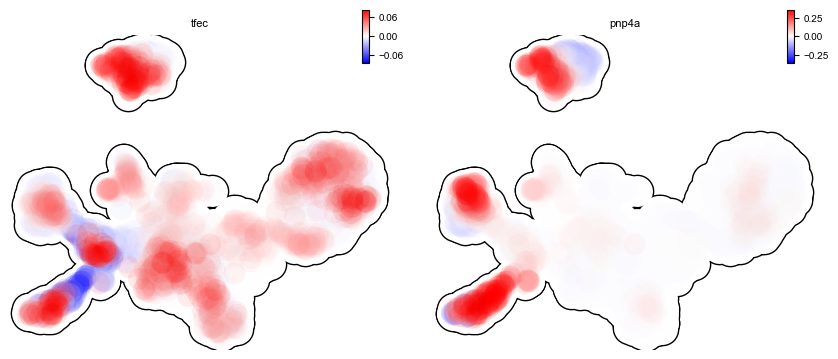

In [12]:
dyn.pl.umap(adata, color=['tfec', 'pnp4a'], layer='velocity_S', frontier=True)

This is for acceleration of genes `tfec` and `pnp4a`. 

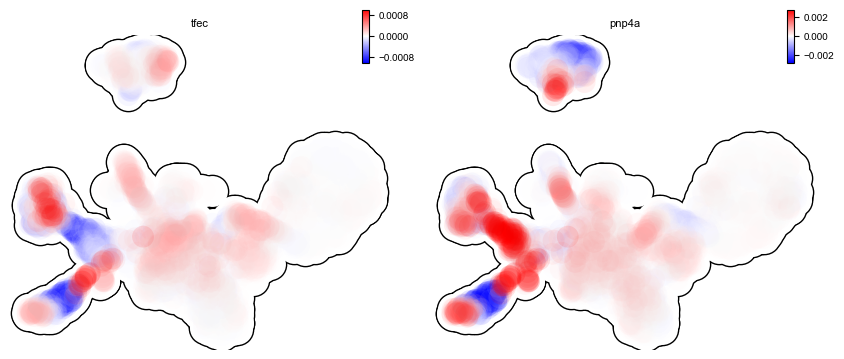

In [13]:
dyn.pl.umap(adata, color=['tfec', 'pnp4a'], layer='acceleration', frontier=True)

This is for curvature of genes `tfec` and `pnp4a`. 

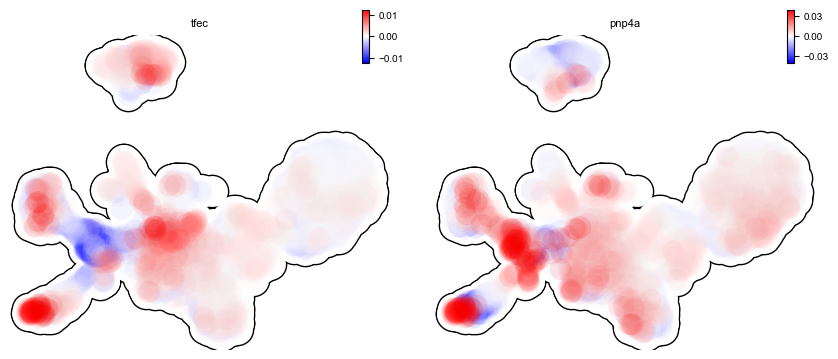

In [14]:
dyn.pl.umap(adata, color=['tfec', 'pnp4a'], layer='curvature', frontier=True)

The purpose for us to develop vaious differential geometry analyses is to derive **functional predictions**.

##### Gene set enrichment  
In this ection, we show our first approach to reveal functional insights with the `dyn.ext.enrichr` function, a python wrapper for Enrichr, to identify biological pathways with statistical significance.

We noticed that the previous study reported a "unknown" cell type from their conventional markers based cell-typing method based on total RNA expression levels. Therefore, we perform gene set enrichment analysis with the top-ranked genes with the highest absolute acceleration from this previously "unknown" cell type. Interestingly, we found the genes were enriched in chondrocyte-related pathways, indicative of a potential chondrocytic origin. 

In [15]:
enr = dyn.ext.enrichr(adata.uns['rank_abs_acceleration']['Unknown'][:250].to_list(), organism='Fish', outdir='./enrichr', gene_sets='GO_Biological_Process_2018')


<AxesSubplot:title={'center':'abs acceleration ranking'}, xlabel='-log$_{10}$(Adjusted P-value)'>

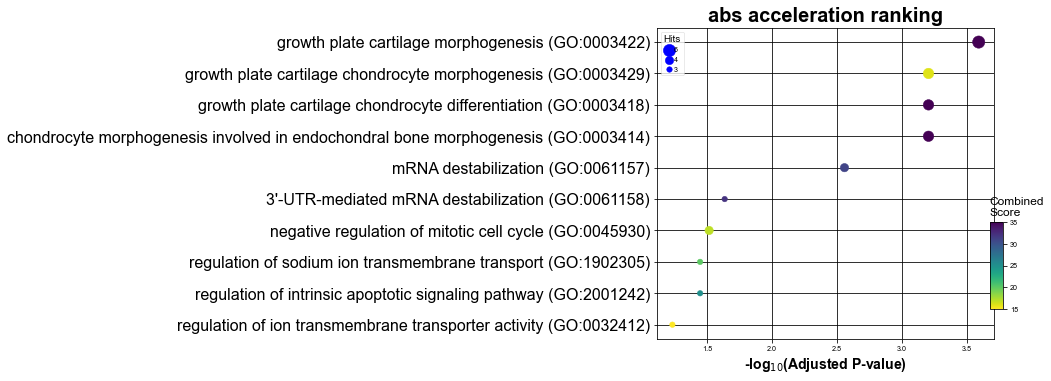

In [16]:
dotplot(enr.res2d, title='abs acceleration ranking', cmap='viridis_r', cutoff=0.1)

#### Jacobian Calculation and Ranking
Next we will calculate Jacobian for each cell with the reconstructed vector field. If we use PCA space, `dyn.vf.jacobian` can project the low dimension Jacobian results back to high dimension to get a cell by gene by gene tensor. You can check the `jacobian_gene` key from the `.uns["jacobian_pca"]` dictionary in the resulted adata object to confirm this.

The cell by gene by gene tensor is generally huge, especially for datasets with large number of cells. We thus would love to do some preprocessing to alleviate the burden of computational resource requirements, either by restricting the calculation to genes that have high loading in our pca analysis or by downsampling the cells that will be used to calculate the `jacobian matrix` in each cell.  

For the first one, we will use `dyn.pp.top_pca_genes` to calculate `top_pca_genes` for adata, according to PCs loading in `adata.uns`. Note that `n_top_genes` below means we take the union of genes with top **n** absolute values for each principal components, so the resulting PCA genes may be larger than 100.

For the second one, we can use the following parameters in `dyn.vf.jacobian`. 

```python 
sampling=None,
sample_ncells=1000,
```

When the sampling is choosen from one of the `'random', 'velocity', 'trn'`, the function will sample `sample_ncells` accord to the sampling method `sample` for the Jacobian matrix calculation in only those sampled cells. We recommend **dynamo** users to start considering sampling cells with your adata object with more than 2500 cells while the top pca gene selected will be around 500. 

In [17]:
dyn.pp.top_pca_genes(adata, n_top_genes=100);

466 top PCA genes found for 30 PCs.


Select top pca genes (flagged in `top_pca_genes` in `.var` after running `pp.top_pca_genes`) and use those genes to set the regulator/effectors that are necessary in cell-wise `jacobian matrix` calculation. 

In [18]:
top_pca_genes = adata.var.index[adata.var.top_pca_genes];

Here we will ensure a set of the chondrocyte-related gene included in the Jacobian calculation so that we can visualize the regulatory network for those genes. You can include other set of genes you care about as long as they are genes used for pca dimension reduction, that is `adata[:, genes].var.use_for_pca` are all `True`.

In [19]:
top_pca_genes = ["erbb3b", "col6a3", "vwa1", "slc35c2", "col6a2", "col6a1"] + list(top_pca_genes)

In [20]:
dyn.vf.jacobian(adata, regulators=top_pca_genes, effectors=top_pca_genes);

Transforming subset Jacobian: 100%|██████████| 4181/4181 [00:46<00:00, 90.20it/s] 


We can take advantage of the cell-wise `jacobian matrix` to investigate gene regulation at single-cell resolution or a state-dependent fashion. 

In iridophore cells, we found that `pnp4a` was potentially activated by `tfec` in the progenitors of iridophore lineage which is line with that reported in Petratou et al. 2021. Futhermore, there seem to have a possible repression occurring when tfec expression level was high in the mature iridophore cells.

We can visualize the regulation from `tfec` to `pnp4a` ($\frac{\partial f_{pnp4a}}{\partial f_{tfec}}$) on the umap embedding. $\frac{\partial f_{pnp4a}}{\partial f_{tfec}}$ denotes the effects of changing the expression of `tfec` to that of `pnp4a`. 

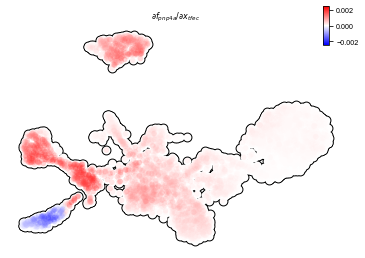

In [21]:
dyn.pl.jacobian(adata, regulators=['tfec'], effectors=['pnp4a'], basis='umap')

Similarly, we can also visualize the regulation from `tfec` to `pnp4a` ($\frac{\partial f_{pnp4a}}{\partial f_{tfec}}$) on top of the gene expression level of `tfec` (*x-axis*) to `pnp4a` (*y-axis*). 

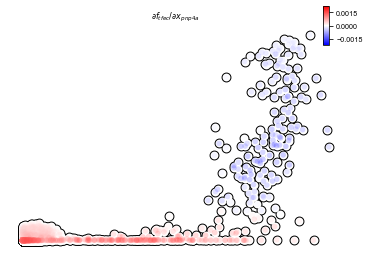

In [22]:
dyn.pl.jacobian(adata, regulators=['pnp4a'], effectors=['tfec'], x='tfec', y="pnp4a", layer='M_s', basis='umap')

##### Ranking for Jacobian matrices

After estimating the cell-wise Jacobian matrix, we now demonstrate different ways to rank genes based on the Jacobian matrix with **dynamo**. 

We start with the so-called "divergence" ranking for each cell group. The "divergence" we are talking about here is different from the definition of `divergence` which is basically the sum of the diagonal elements of the Jacobian. Instead the `divergence` in this context points to the self-activation or self-inhibition terms. 

The results of divergence ranking are stored in `adata.uns['rank_div_gene_jacobian_pca']`.

In [23]:
divergence_rank = dyn.vf.rank_divergence_genes(adata, groups='Cell_type');

We can rank all other elements in the Jacobian. There are 5 parameters we provide in `dyn.vf.rank_jacobian_genes`'s argument list to rank the Jacobian:

* "full reg" or "full_reg": top regulators are ranked for each effector for each cell group

* "full eff" or "full_reff": top effectors are ranked for each regulator for each cell group

* "reg": top regulators in each cell group

* "eff": top effectors in each cell group

* "int": top effector-regulator pairs in each cell group

Note that the default mode is "full reg". More details can be found on API pages of online documentation. `dyn.vf.rank_jacobian_genes`

In [24]:
full_reg_rank = dyn.vf.rank_jacobian_genes(adata, 
                                           groups='Cell_type', 
                                           mode="full_reg", 
                                           abs=True, 
                                           output_values=True)

In [25]:
full_eff_rank = dyn.vf.rank_jacobian_genes(adata, 
                                           groups='Cell_type', 
                                           mode='full_eff', 
                                           abs=True, 
                                           exclude_diagonal=True, 
                                           output_values=True)

The results of full_eff and full_reg are dictionaries, whose keys are cluster (cell type in the case above) names and values are `pd.DataFrame` with rank information as well as coefficient values stored for each gene. See below:

In [26]:
type(full_reg_rank)

dict

In [27]:
print(full_reg_rank['Unknown'].shape)
full_reg_rank["Unknown"].head(2)

(469, 938)


,tmsb4x,tmsb4x_values,rplp2l,rplp2l_values,pvalb1,pvalb1_values,gfap,gfap_values,ptmab,ptmab_values,...,sytl2b,sytl2b_values,ccna2,ccna2_values,ddc,ddc_values,top2a,top2a_values,slc6a2,slc6a2_values
0,mbpb,0.001429,pmp22a,0.001778,fosab,0.001519,mt2,0.000966,hmgn2,0.003356,...,pnp4a,0.000666,hmgn2,0.001188,tubb5,0.000309,hmgn2,0.001015,tubb5,0.000300
1,si:ch211-156j16.1,0.001422,nfkbiab,0.001710,mcl1b,0.001041,fabp3,0.000836,pmp22b,0.002125,...,fhl2a,0.000642,hmgb2a,0.000691,elavl4,0.000297,hmgb2a,0.000542,si:ch211-222l21.1,0.000295


In [28]:
eff_rank = dyn.vf.rank_jacobian_genes(adata, groups='Cell_type', mode='eff', abs=True, output_values=True)

In [29]:
reg_rank = dyn.vf.rank_jacobian_genes(adata, groups='Cell_type', mode='reg', abs=True, exclude_diagonal=True)

`int` stands for interactions, the pairs of (gene1, gene2) values in jacobian matrix.

In [30]:
int_rank = dyn.vf.rank_jacobian_genes(adata, groups='Cell_type', mode='int', exclude_diagonal=True, output_values=True)

##### Construct and visualize cell-type specific regulatory networks

With the `full_reg_rank` and `full_eff_rank` calculated, we can now pass a set of genes of interests and use them to build a regulatory network for any specific cell type and then visualize the network with either an arcPlot or a circosPlot, etc. 

We build networks for each cell type. The edges and their weights are from `full_reg_rank` and `full_eff_rank`.

Interesting, Jacobian analysis revealed potential regulation of the chondrocyte marker `slc36c2` by the pigment regulator `erbb3`, consistent with previous reports that `EGFR (erbb3)` signaling is critical for maintaining the chondrocyte lineage (Fisher et al. 2007). In addition, this analysis revealed a strong connection between chondrocyte-specific markers `col6a3`, `col6a`, `col6a2`, and `vwa1`. 

Here we will use a few key gene in the “unknown” cell cluster to build a regulatory network based on the estimated cell- wise Jacobian matrices of chondrocyte cells. 

In [31]:
unknown_cell_type_regulators = ["erbb3b", "col6a3", "vwa1", "slc35c2", "col6a2", "col6a1"]
edges_list = dyn.vf.build_network_per_cluster(adata,
                                              cluster='Cell_type',
                                              cluster_names=None,
                                              full_reg_rank=full_reg_rank,
                                              full_eff_rank=full_eff_rank,
                                              genes=np.unique(unknown_cell_type_regulators),
                                              n_top_genes=100)

import networkx as nx
network = nx.from_pandas_edgelist(edges_list['Unknown'], 'regulator', 'target', edge_attr='weight', create_using=nx.DiGraph())

|-----> [iterating reg_groups] in progress: 100.0000%
|-----> [iterating reg_groups] finished [23.2610s]


Network can then be visualized as an Arcplot: 

[5, 12, 8, 3, 8, 10]


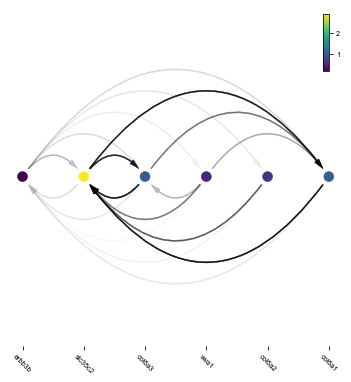

In [32]:
ax=dyn.pl.arcPlot(adata, cluster="Cell_type", cluster_name="Unknown", edges_list=None, network=network, color="M_s")

Similarly, network can then be built with other criteria and visualized with other plots, like the circos plot or hive Plot. For example, we can select 10 top genes with highest absolute acceleration values in `Unknown` cell type.

In [33]:
selected_genes = adata.uns['rank_abs_acceleration']['Unknown'][:10]

In [34]:
edges_list = dyn.vf.build_network_per_cluster(adata,
                                              cluster='Cell_type',
                                              cluster_names=None,
                                              full_reg_rank=full_reg_rank,
                                              full_eff_rank=full_eff_rank,
                                              genes=selected_genes,
                                              n_top_genes=1000)


|-----> [iterating reg_groups] in progress: 100.0000%
|-----> [iterating reg_groups] finished [10.1881s]


We can then focus on analyzing `Unknown` cell type network and construct networkx graph structure for `Unknown` cell group. We next constrain the edges by removing all edges with weight <= 0.002.

In [35]:
network = nx.from_pandas_edgelist(edges_list['Unknown'].drop_duplicates().query("weight > 0.0015"), 
                                  'regulator', 'target', 
                                  edge_attr='weight', 
                                  create_using=nx.DiGraph())

Lastly, we can visulize the network with `dyn.pl.circosPlot`.

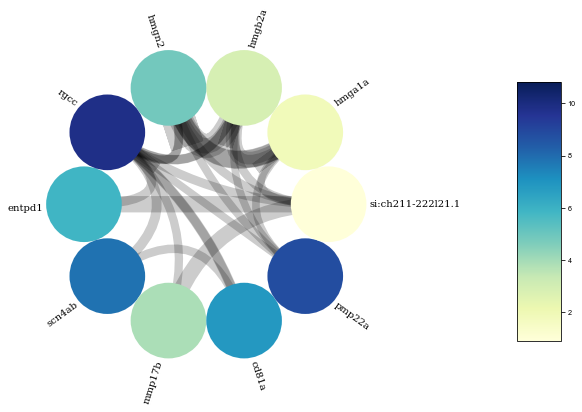

In [36]:
dyn.pl.circosPlot(adata, 
                  cluster="Cell_type", 
                  cluster_name="Unknown", 
                  edges_list=None, 
                  network=network, color="M_s", )

#### Visualize gene expression, velocity, acceleration, curvature as a function of vector field based pseudotime. 

Here we can apply `ddhodge` to first obtain a measure of pseudotime that is based on learned vector field function. Then we can visualize gene expression, velocity, acceleration, curvature as a function of vector field based pseudotime to reveal different aspects of gene expression kinetics over time. 

The kinetic heatmap shown below indicates that there are a few distinct stages of gene expression changes (or velocity, acceleration, curvature, etc.) during zebrafish pigmentation. 

In [37]:
dyn.ext.ddhodge(adata, basis='pca')

|-----> [graphize_vecfld] in progress: 100.0000%
|-----> [graphize_vecfld] finished [158.2472s]


In [38]:
transition_genes = adata.var_names[adata.var.use_for_transition]

Visualize the **gene expression dynamics** as a function of vector field based pseudotime (*x-axis*). 

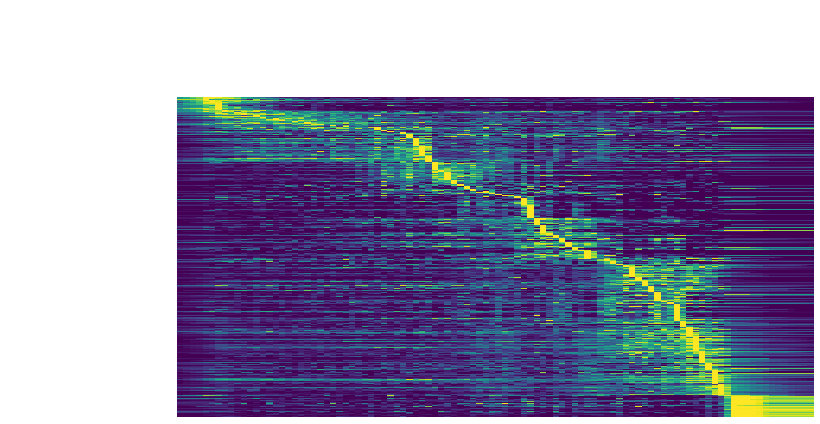

In [39]:
dyn.pl.kinetic_heatmap(adata, 
                       genes=transition_genes, 
                       tkey='pca_ddhodge_potential',
                       gene_order_method='maximum', 
                       mode='pseudotime', 
                       color_map='viridis',
                       yticklabels=False,    
                      )

<Figure size 600x400 with 0 Axes>

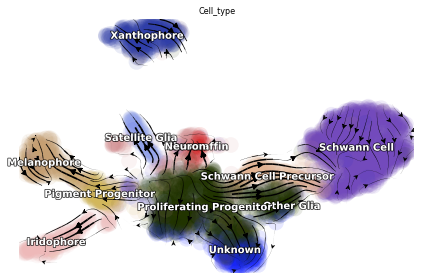

In [40]:
dyn.pl.streamline_plot(adata, color='Cell_type')

Note that if you want to visualize the gene expression for specific cell lineage, you can subset the adata via something like (the same applies to other kinetic heatmaps): 

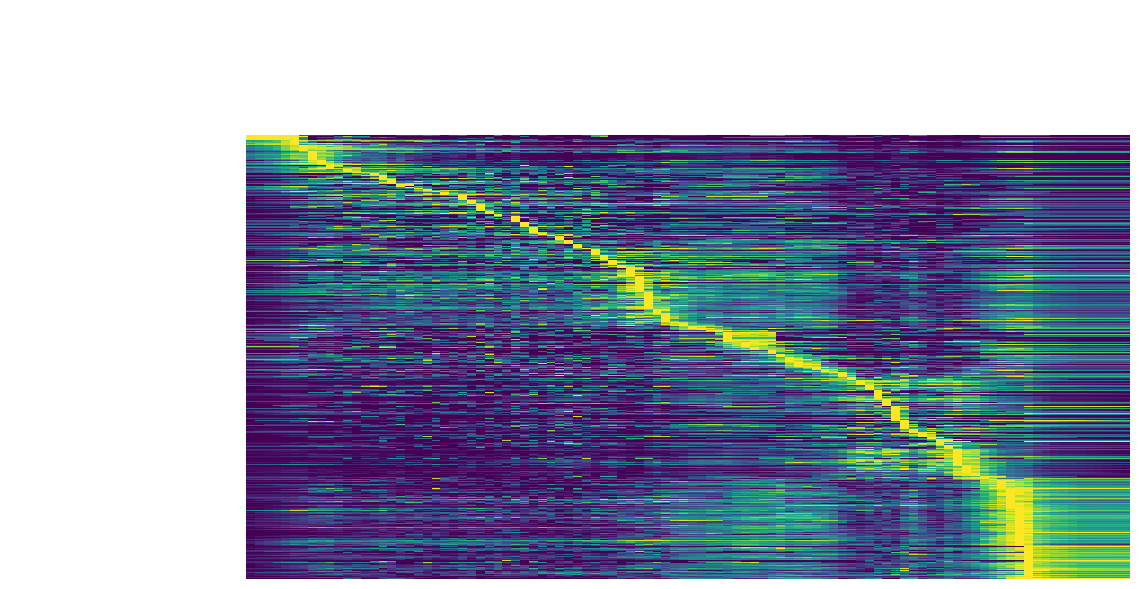

In [41]:
subset = adata[adata.obs.Cell_type.isin(['Proliferating Progenitor', 'Pigment Progenitor', 'Melanophore'])]

dyn.pl.kinetic_heatmap(subset, 
                       genes=transition_genes, 
                       tkey='pca_ddhodge_potential',
                       gene_order_method='maximum', 
                       mode='pseudotime', 
                       color_map='viridis',
                       yticklabels=False,    
                      )

Visualize the **gene velocity dynamics** as a function of vector field based pseudotime (*x-axis*). 

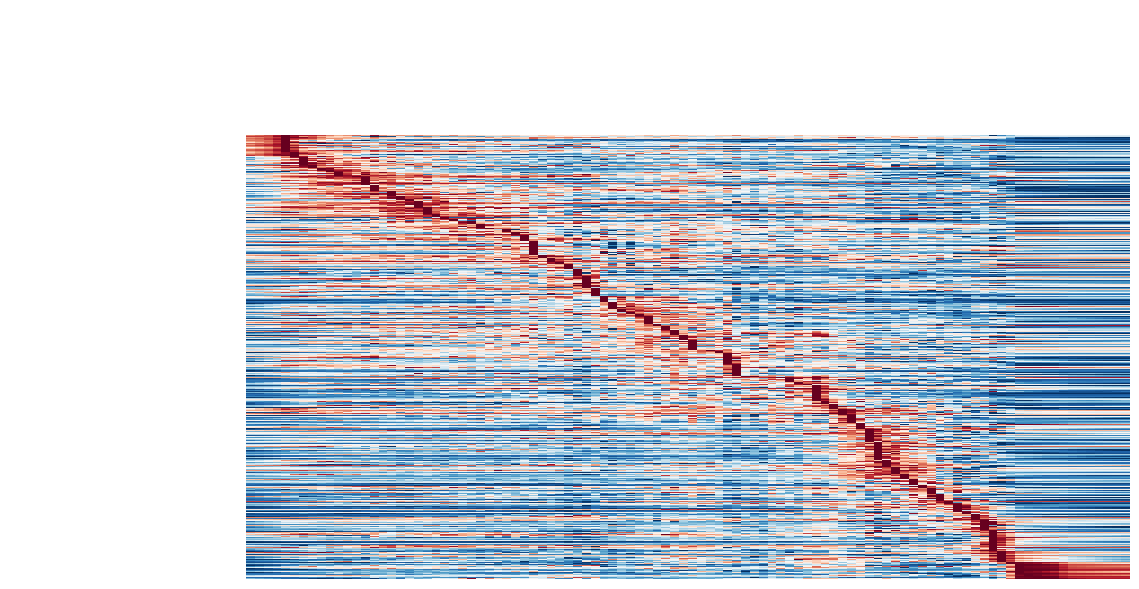

In [42]:
dyn.pl.kinetic_heatmap(adata, 
                       genes=transition_genes, 
                       tkey='pca_ddhodge_potential',
                       gene_order_method='maximum', 
                       layer='velocity_S',
                       mode='pseudotime', 
                       color_map='RdBu_r',
                       yticklabels=False,  
                      )

Visualize the **gene acceleration dynamics** as a function of vector field based pseudotime (*x-axis*). 

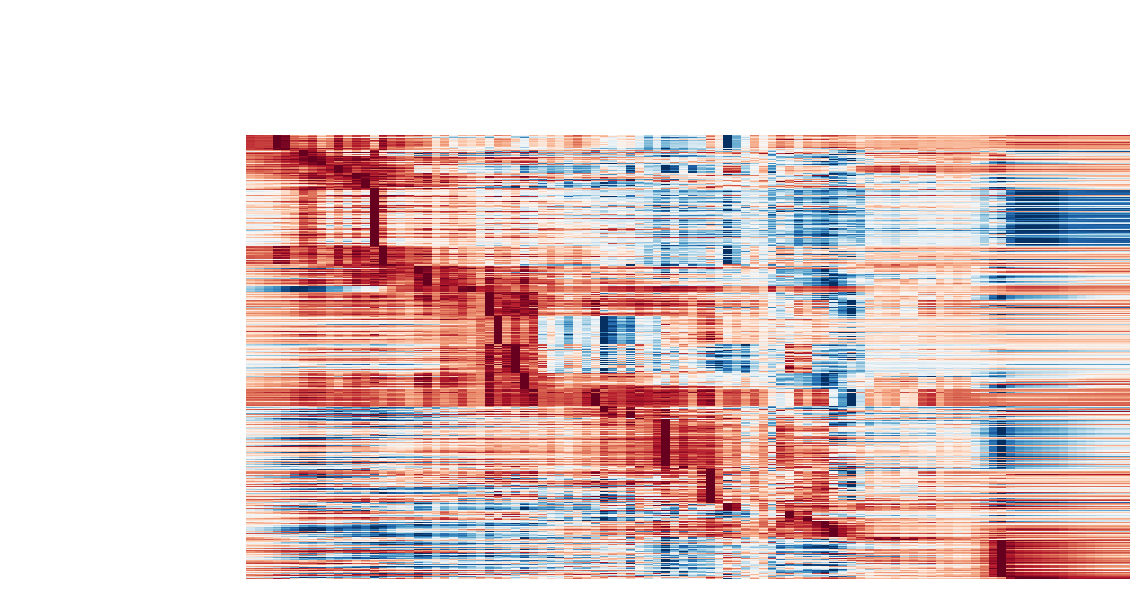

In [43]:
dyn.pl.kinetic_heatmap(adata, 
                       genes=transition_genes, 
                       tkey='pca_ddhodge_potential',
                       gene_order_method='maximum', 
                       layer='acceleration',
                       mode='pseudotime', 
                       yticklabels=False,  
                       color_map='RdBu_r')

Visualize the **gene curvature dynamics** as a function of vector field based pseudotime (*x-axis*). 

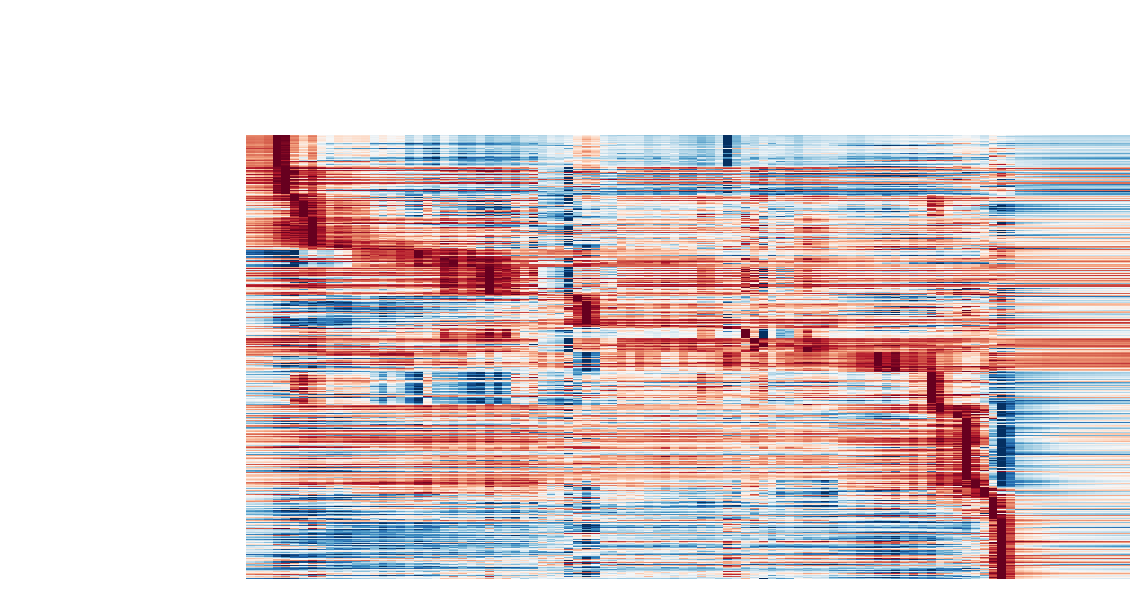

In [44]:
dyn.pl.kinetic_heatmap(adata, 
                       genes=transition_genes, 
                       tkey='pca_ddhodge_potential',
                       gene_order_method='maximum', 
                       layer='curvature',
                       mode='pseudotime', 
                       yticklabels=False,  
                       color_map='RdBu_r')

#### Build transition graph between cell states

When projecting high-dimensional RNA velocity vectors into low-dimensional space, **dynamo** builds a cell-wise transition matrix by translating the velocity vector direction and the spatial relationship of each cell to its neighbors to transition probabilities, similar to velocyto, etc. **dynamo** uses a few different kernels to build such a transition matrix which can then be used to run Markov chain simulations, as we will demonstrate in future. 

On the other hand, it is of great interests to obtain a transition graph between cell types (states). **dynamo** implements such a functionality with a few methods which effectively creates a model that summarizes the possible cell type transitions based on the reconstructed markov transition matrix between cell or the vector field function. 

To achieve this, we only need to build a state graph with `dyn.pd.state_graph` in a specific basis for a speicifc grouping. For example, we can use the vector field integration based method `vf` to build a transition graph between different cell types: 

In [45]:
%%capture
dyn.prediction.state_graph(adata, group='Cell_type', basis='pca', method='vf')

|-----> Estimating the transition probability between cell types...
|-----> Applying vector field
|-----> [KDTree parameter preparation computation] in progress: 0.0000%
|-----> [KDTree computation] finished [0.0023s]
|-----> [iterate groups] in progress: 100.0000%
|-----> [iterate groups] finished [143.9189s]
|
|-----> [State graph estimation] finished [0.0017s]


Next, a state graph can be visualized with `dyn.pl.state_graph`.

<Figure size 640x480 with 0 Axes>

<Figure size 600x400 with 0 Axes>

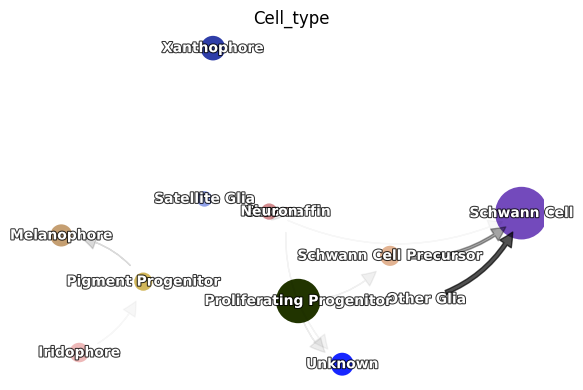

In [46]:
dyn.pl.state_graph(adata, 
                   color=['Cell_type'], 
                   group='Cell_type', 
                   basis='umap', 
                   show_legend='on data',
                   method='vf');

### Save results

#### save ranking information to an excel file

**dynamo** provides an utility function to automatically save the ranking related data frames to an excel file with each ranking information saved to a separate sheet in the xlsx file. 

In [47]:
dyn.export_rank_xlsx(adata, path="rank_info.xlsx")

|-----> saving sheet: rank_velocity_S
|-----> saving sheet: rank_abs_velocity_S
|-----> saving sheet: rank_acceleration
|-----> saving sheet: rank_abs_acceleration
|-----> saving sheet: rank_curvature
|-----> saving sheet: rank_abs_curvature
|-----> saving sheet: rank_div_gene_jacobian_pca


#### Save data with pickle dumping or pandas dataframe to_csv

You can directly either export data to a csv file via:  

```python
adata.uns['rank_acceleration'].to_csv('./zebrafish_vf_rank_acceleration.csv')
```
Alternatively, you can directly save the data via pickle:  

```python
import pickle

pickle.dump(adata.uns['rank_acceleration'], open('./zebrafish_vf_rank_acceleration.p', 'wb'))
pickle.dump(full_reg_rank, open('./zebrafish_vf_full_reg_rank.p', 'wb'))

_acceleration_rank = pickle.load(open('./zebrafish_vf_rank_acceleration.p', 'rb'))
_acceleration_rank.head(2)
```


#### Dynamo save utility

Note that there may be intermediate results stored in adata.uns that can may lead to an error when writing the `h5ad` object. For now, we suggest users to call `dyn.cleanup(adata)` first to remove these data objects before saving the adata object.

In [48]:
dyn.cleanup(adata);

call `AnnData` `write_h5ad` to save the entire adata information.

In [49]:
adata.write_h5ad("./tutorial_processed_zebrafish_data.h5ad")

You can load in the data later if need: 

```python
_adata = dyn.read_h5ad(("./tutorial_processed_zebrafish_data.h5ad"))
```